# RAG System Evaluation Suite

Production-grade evaluation framework for financial AI assistant using structured LLM judges.

**Metrics**: Number Accuracy • Answer Correctness • Faithfulness • RAG Success

## Setup

In [1]:
import asyncio
import json
import os
import sys
import time
import re
from typing import Dict, Any, List, Optional

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from litellm import completion
from supabase import create_client
from pydantic import BaseModel, Field

# Add project root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from evaluation.config import (
    GOLDEN_DATASET_PATH, EVAL_RESULTS_PATH, JUDGE_MODEL,
    TEST_USER_EMAIL, TEST_USER_PASSWORD, SUPABASE_URL, SUPABASE_KEY
)
from api.v1.dependencies import Session
from src.llm.workflow.react_rag import run_react_rag

print(f"✓ Project root: {project_root}")
print(f"✓ Judge model: {JUDGE_MODEL}")

✓ Project root: c:\Users\wbrya\OneDrive\Documents\GitHub\AI-CFO-FYP
✓ Judge model: gemini/gemini-2.5-flash-lite


## Data Models

In [2]:
class EvaluationResult(BaseModel):
    """LLM judge evaluation result."""
    number_accuracy: str = Field(description="PASS or FAIL")
    answer_correctness: str = Field(description="PASS or FAIL")
    faithfulness: str = Field(description="PASS or FAIL")
    rag_success: str = Field(description="PASS or FAIL")
    explanation: str = Field(description="Brief reasoning")

class ErrorPattern(BaseModel):
    """Error classification."""
    error_type: str
    severity: str  # HIGH, MEDIUM, LOW
    description: str

class PerformanceMetrics(BaseModel):
    """Performance tracking."""
    execution_time_seconds: float
    tokens_estimated: int
    cost_estimate_usd: float
    retrieval_calls: int
    context_length_chars: int

class TestResult(BaseModel):
    """Complete test case result."""
    test_id: str
    question: str
    ideal_answer: str
    generated_answer: str
    retrieved_context: str
    tags: List[str]
    
    # System metrics
    execution_success: bool
    execution_error: Optional[str] = None
    
    # Performance
    performance: PerformanceMetrics
    
    # Evaluation
    number_accuracy: str
    answer_correctness: str
    faithfulness: str
    rag_success: str
    evaluation_explanation: str
    
    # Errors
    error_patterns: List[ErrorPattern]

def estimate_tokens(text: str) -> int:
    """Estimate token count."""
    return int(len(text) / 3.5 * 1.1) if text else 0

def estimate_cost(tokens: int) -> float:
    """Estimate cost for Gemini."""
    return (tokens / 1000) * 0.00125  # Gemini pricing

print("✓ Models defined")

✓ Models defined


## Authentication

In [3]:
async def setup_auth():
    """Setup authentication."""
    client = create_client(SUPABASE_URL, SUPABASE_KEY)
    
    response = await asyncio.to_thread(
        client.auth.sign_in_with_password,
        {"email": TEST_USER_EMAIL, "password": TEST_USER_PASSWORD}
    )
    
    session = Session(
        user_id=response.user.id, 
        token=response.session.access_token
    )
    
    client.options.headers["Authorization"] = f"Bearer {session.token}"
    
    return session, client

session, supabase_client = await setup_auth()
print(f"✓ Authenticated: {session.user_id[:8]}...")

✓ Authenticated: 372ec112...


## Dataset

In [4]:
def load_dataset() -> List[Dict[str, Any]]:
    """Load test cases."""
    with open(GOLDEN_DATASET_PATH, 'r') as f:
        dataset = json.load(f)
    
    # Validate structure
    required = ['test_id', 'question', 'ideal_answer', 'tags']
    for item in dataset:
        missing = [field for field in required if field not in item]
        if missing:
            raise ValueError(f"Missing fields: {missing}")
    
    return dataset

golden_dataset = load_dataset()
print(f"✓ Loaded {len(golden_dataset)} test cases")

# Show distribution
all_tags = [tag for item in golden_dataset for tag in item['tags']]
tag_counts = pd.Series(all_tags).value_counts()
print(f"Tags: {dict(tag_counts)}")

✓ Loaded 10 test cases
Tags: {'accuracy': np.int64(8), 'single-doc': np.int64(5), 'multi-doc': np.int64(3), 'negative-value': np.int64(2), 'calculation': np.int64(2), 'aggregation': np.int64(2), 'scaling': np.int64(1), 'comparison': np.int64(1), 'no-answer': np.int64(1), 'robustness': np.int64(1), 'charting': np.int64(1), 'tool-use': np.int64(1), 'expenses': np.int64(1)}


## Core Functions

In [5]:
async def get_rag_response(question: str, session: Session, client) -> Dict[str, Any]:
    """Get RAG response with context extraction and completion validation."""
    start_time = time.time()
    
    try:
        final_answer = ""
        context_chunks = []
        retrieval_calls = 0
        
        # Track if we're in the middle of a calculation
        calculation_in_progress = False
        last_chunk_time = time.time()
        max_wait_time = 60  # Maximum wait time in seconds
        
        async for chunk in run_react_rag(session, client, question, []):
            final_answer += chunk
            last_chunk_time = time.time()
            
            # Check if calculation is starting
            chunk_lower = chunk.lower()
            if any(phrase in chunk_lower for phrase in [
                'i will calculate', 'let me calculate', 'calculating', 
                'i will now', 'recalculating', 'i will execute'
            ]):
                calculation_in_progress = True
            
            # Check if calculation is completed
            if calculation_in_progress and is_calculation_complete(chunk):
                calculation_in_progress = False
            
            # Extract context using multiple patterns
            # Pattern 1: JSON content
            if '"content":' in chunk:
                context_chunks.append(chunk)
                retrieval_calls += 1
            
            # Pattern 2: Financial indicators
            elif any(term in chunk_lower for term in [
                'revenue', 'income', 'profit', 'loss', 'expense'
            ]) and len(chunk) > 50:
                context_chunks.append(chunk)
            
            # Pattern 3: Document indicators
            elif any(term in chunk_lower for term in [
                'retrieved', 'document', 'statement', 'financial'
            ]):
                context_chunks.append(chunk)
        
        # Post-processing: Ensure calculation completion
        if calculation_in_progress:
            # Wait a bit more for completion
            wait_count = 0
            while calculation_in_progress and wait_count < 5:
                await asyncio.sleep(1)
                wait_count += 1
                
                # Check if response looks complete now
                if is_calculation_complete(final_answer):
                    calculation_in_progress = False
            
            # If still incomplete, try to complete it
            if calculation_in_progress:
                final_answer = complete_truncated_response(final_answer, question)
        
        # Validate response quality
        quality_check = validate_response_quality(final_answer, question)
        if not quality_check['is_complete']:
            final_answer = fix_incomplete_response(final_answer, question, quality_check)
        
        # Process extracted context
        retrieved_context = ""
        if context_chunks:
            all_context = "\n".join(context_chunks)
            
            # Extract JSON content values
            content_matches = re.findall(r'"content":\s*"([^"]+)"', all_context)
            if content_matches:
                retrieved_context = "\n".join(content_matches[:10])
            else:
                # Fallback to filtered chunks
                financial_chunks = [
                    chunk for chunk in context_chunks 
                    if len(chunk) > 30 and any(
                        term in chunk.lower() for term in [
                            'revenue', 'income', 'profit', 'financial'
                        ]
                    )
                ]
                retrieved_context = "\n".join(financial_chunks[:5])
        
        if not retrieved_context:
            retrieved_context = "No relevant context extracted"
        
        execution_time = time.time() - start_time
        
        return {
            "answer": final_answer.strip(),
            "context": retrieved_context,
            "success": True,
            "retrieval_calls": retrieval_calls,
            "execution_time": execution_time,
            "error": None
        }
        
    except Exception as e:
        return {
            "answer": f"ERROR: {str(e)}",
            "context": "No context due to error",
            "success": False,
            "retrieval_calls": 0,
            "execution_time": time.time() - start_time,
            "error": str(e)
        }

def is_calculation_complete(text: str) -> bool:
    """Check if calculation appears to be completed."""
    if not text:
        return False
    
    # Look for actual completed calculations
    completion_indicators = [
        r'\$[\d,]+\.?\d*',  # Dollar amounts like $10,000 or $550,000
        r'\d+\.\d+%',       # Percentages like 63.33%
        r'=\s*\$[\d,]+',    # Equals followed by dollar amount
        r'total.*\$[\d,]+', # Total followed by dollar amount
        r'result.*\$[\d,]+', # Result followed by dollar amount
    ]
    
    # Check if we have actual numerical results
    has_numbers = any(re.search(pattern, text, re.IGNORECASE) for pattern in completion_indicators)
    
    # Check if response doesn't end with incomplete phrases
    incomplete_endings = [
        'i will calculate', 'let me calculate', 'calculating', 
        'i will now', 'recalculating', 'i will execute',
        'calculating now', 'let me', 'i will'
    ]
    
    last_part = text.lower().strip()[-50:]  # Check last 50 characters
    ends_incomplete = any(ending in last_part for ending in incomplete_endings)
    
    return has_numbers and not ends_incomplete

def validate_response_quality(response: str, question: str) -> Dict[str, Any]:
    """Validate if response is complete and addresses the question."""
    
    issues = []
    is_complete = True
    
    # Check for truncation indicators
    truncation_phrases = [
        'i will calculate', 'let me calculate', 'calculating now',
        'i will now', 'recalculating', 'i will execute'
    ]
    
    response_lower = response.lower()
    for phrase in truncation_phrases:
        if phrase in response_lower[-100:]:  # Check last 100 chars
            issues.append(f"Response ends with incomplete phrase: '{phrase}'")
            is_complete = False
    
    # Check if calculation was requested but no numbers provided
    if 'calculate' in question.lower() or 'total' in question.lower():
        if not re.search(r'\$[\d,]+|\d+\.\d+%', response):
            issues.append("Calculation requested but no numerical results provided")
            is_complete = False
    
    # Check minimum response length
    if len(response.strip()) < 30:
        issues.append("Response too short")
        is_complete = False
    
    return {
        'is_complete': is_complete,
        'issues': issues,
        'response_length': len(response)
    }

def fix_incomplete_response(response: str, question: str, quality_check: Dict[str, Any]) -> str:
    """Fix incomplete responses based on quality issues."""
    
    fixed_response = response
    
    # If response ends with incomplete calculation phrases
    for issue in quality_check['issues']:
        if 'incomplete phrase' in issue:
            fixed_response += "\n\n[Note: The calculation was interrupted. Based on the available data, please refer to the source documents for the specific figures requested.]"
            break
    
    # If calculation was requested but not provided
    if any('numerical results' in issue for issue in quality_check['issues']):
        fixed_response += "\n\n[Note: The requested calculation could not be completed automatically. Please verify the figures in the source documents.]"
    
    return fixed_response

def complete_truncated_response(response: str, question: str) -> str:
    """Attempt to complete a truncated response."""
    
    # If response ends with calculation promise, add completion message
    if any(phrase in response.lower()[-100:] for phrase in [
        'i will calculate', 'let me calculate', 'calculating', 
        'i will now', 'recalculating', 'i will execute'
    ]):
        response += "\n\n[Calculation was interrupted. The system was in the process of computing the requested values but the response was truncated. Please try your query again for the complete calculation.]"
    
    return response

async def llm_evaluate(
    question: str, 
    generated_answer: str, 
    ideal_answer: str, 
    retrieved_context: str
) -> EvaluationResult:
    """Evaluate using LLM judge."""
    
    if "ERROR:" in generated_answer:
        return EvaluationResult(
            number_accuracy="FAIL",
            answer_correctness="FAIL",
            faithfulness="FAIL",
            rag_success="FAIL",
            explanation="System error prevented evaluation"
        )
    
    prompt = f"""Evaluate this RAG system response across four dimensions.

QUESTION: {question}

EXPECTED: {ideal_answer}

GENERATED: {generated_answer}

CONTEXT: {retrieved_context}

Evaluate:
1. NUMBER ACCURACY: Are numerical values correct? (PASS if numbers match, minor formatting OK)
2. ANSWER CORRECTNESS: Does it address the question? (PASS if core information provided)
3. FAITHFULNESS: Grounded in context? (PASS if no hallucination)
4. RAG SUCCESS: Overall system performance? (PASS if useful response)

Be practical, not overly strict. Focus on user value.

Respond with JSON:
{{
  "number_accuracy": "PASS" or "FAIL",
  "answer_correctness": "PASS" or "FAIL", 
  "faithfulness": "PASS" or "FAIL",
  "rag_success": "PASS" or "FAIL",
  "explanation": "Brief reasoning"
}}"""
    
    try:
        response = completion(
            model=JUDGE_MODEL,
            messages=[{"role": "user", "content": prompt}],
            response_format=EvaluationResult,
            temperature=0.0
        )
        
        content = response.choices[0].message.content.strip()
        result_dict = json.loads(content)
        return EvaluationResult(**result_dict)
        
    except Exception as e:
        return EvaluationResult(
            number_accuracy="FAIL",
            answer_correctness="FAIL",
            faithfulness="FAIL",
            rag_success="FAIL",
            explanation=f"Evaluation failed: {str(e)}"
        )

def analyze_errors(result_data: Dict[str, Any]) -> List[ErrorPattern]:
    """Analyze error patterns."""
    patterns = []
    
    # System errors
    if not result_data.get('execution_success', True):
        error_msg = str(result_data.get('execution_error', '')).lower()
        
        if 'timeout' in error_msg or 'connection' in error_msg:
            patterns.append(ErrorPattern(
                error_type="network_error",
                severity="HIGH",
                description="Network or timeout issue"
            ))
        elif 'retrieval' in error_msg or 'supabase' in error_msg:
            patterns.append(ErrorPattern(
                error_type="retrieval_failure",
                severity="HIGH",
                description="Retrieval system failure"
            ))
        else:
            patterns.append(ErrorPattern(
                error_type="system_error",
                severity="MEDIUM",
                description="General system error"
            ))
    
    # Quality issues
    if result_data.get('faithfulness') == 'FAIL':
        context_length = len(result_data.get('retrieved_context', ''))
        if context_length < 50:
            patterns.append(ErrorPattern(
                error_type="retrieval_failure",
                severity="HIGH",
                description="Insufficient context retrieved"
            ))
        else:
            patterns.append(ErrorPattern(
                error_type="hallucination",
                severity="HIGH",
                description="Response not grounded in context"
            ))
    
    if result_data.get('number_accuracy') == 'FAIL':
        patterns.append(ErrorPattern(
            error_type="calculation_error",
            severity="MEDIUM",
            description="Numerical value extraction error"
        ))
    
    # Performance issues
    exec_time = result_data.get('execution_time', 0)
    if exec_time > 45:
        patterns.append(ErrorPattern(
            error_type="performance_issue",
            severity="MEDIUM",
            description=f"Slow response: {exec_time:.1f}s"
        ))
    
    return patterns

print("✓ Core functions defined")

✓ Core functions defined


## Evaluation Pipeline

In [6]:
async def evaluate_test_case(test_case: Dict[str, Any]) -> TestResult:
    """Evaluate single test case."""
    test_id = test_case['test_id']
    question = test_case['question']
    ideal_answer = test_case['ideal_answer']
    tags = test_case['tags']
    
    print(f"  {test_id}: {question[:60]}...")
    
    # Get RAG response
    response = await get_rag_response(question, session, supabase_client)
    generated_answer = response['answer']
    retrieved_context = response['context']
    
    # Calculate metrics
    tokens = estimate_tokens(generated_answer)
    cost = estimate_cost(tokens)
    
    performance = PerformanceMetrics(
        execution_time_seconds=response['execution_time'],
        tokens_estimated=tokens,
        cost_estimate_usd=cost,
        retrieval_calls=response['retrieval_calls'],
        context_length_chars=len(retrieved_context)
    )
    
    print(f"    Time: {performance.execution_time_seconds:.2f}s, Cost: ${cost:.4f}")
    
    # LLM evaluation
    evaluation = await llm_evaluate(
        question, generated_answer, ideal_answer, retrieved_context
    )
    
    # Error analysis
    result_data = {
        'execution_success': response['success'],
        'execution_error': response['error'],
        'faithfulness': evaluation.faithfulness,
        'number_accuracy': evaluation.number_accuracy,
        'retrieved_context': retrieved_context,
        'execution_time': response['execution_time']
    }
    
    error_patterns = analyze_errors(result_data)
    
    result = TestResult(
        test_id=test_id,
        question=question,
        ideal_answer=ideal_answer,
        generated_answer=generated_answer,
        retrieved_context=retrieved_context,
        tags=tags,
        execution_success=response['success'],
        execution_error=response['error'],
        performance=performance,
        number_accuracy=evaluation.number_accuracy,
        answer_correctness=evaluation.answer_correctness,
        faithfulness=evaluation.faithfulness,
        rag_success=evaluation.rag_success,
        evaluation_explanation=evaluation.explanation,
        error_patterns=error_patterns
    )
    
    # Status summary
    metrics = f"Acc:{evaluation.number_accuracy}, Corr:{evaluation.answer_correctness}, Faith:{evaluation.faithfulness}, RAG:{evaluation.rag_success}"
    errors = f", Errors: {len(error_patterns)}" if error_patterns else ""
    print(f"    {metrics}{errors}")
    
    return result

async def run_evaluation() -> pd.DataFrame:
    """Run complete evaluation."""
    print("\n" + "="*50)
    print("RAG SYSTEM EVALUATION")
    print("="*50)
    
    results = []
    total_cost = 0.0
    total_time = 0.0
    
    for i, test_case in enumerate(golden_dataset):
        print(f"\n[{i+1}/{len(golden_dataset)}] {test_case['test_id']}")
        
        try:
            result = await evaluate_test_case(test_case)
            results.append(result.model_dump())
            
            total_cost += result.performance.cost_estimate_usd
            total_time += result.performance.execution_time_seconds
            
        except Exception as e:
            print(f"    ERROR: {e}")
            
            # Create error result
            error_result = TestResult(
                test_id=test_case['test_id'],
                question=test_case['question'],
                ideal_answer=test_case['ideal_answer'],
                generated_answer=f"SYSTEM_ERROR: {str(e)}",
                retrieved_context="No context due to error",
                tags=test_case['tags'],
                execution_success=False,
                execution_error=str(e),
                performance=PerformanceMetrics(
                    execution_time_seconds=0.0,
                    tokens_estimated=0,
                    cost_estimate_usd=0.0,
                    retrieval_calls=0,
                    context_length_chars=0
                ),
                number_accuracy="FAIL",
                answer_correctness="FAIL",
                faithfulness="FAIL",
                rag_success="FAIL",
                evaluation_explanation=f"Test failed: {str(e)}",
                error_patterns=[ErrorPattern(
                    error_type="system_error",
                    severity="HIGH",
                    description=f"Test execution failed: {str(e)}"
                )]
            )
            results.append(error_result.model_dump())
        
        # Rate limiting
        if i < len(golden_dataset) - 1:
            await asyncio.sleep(2)
    
    # Save results
    results_df = pd.DataFrame(results)
    output_path = EVAL_RESULTS_PATH.replace('.csv', '_pro.csv')
    results_df.to_csv(output_path, index=False)
    
    # Summary
    avg_time = total_time / len(golden_dataset)
    avg_cost = total_cost / len(golden_dataset)
    
    print(f"\n" + "="*50)
    print("EVALUATION COMPLETE")
    print(f"Results saved: {output_path}")
    print(f"Total cost: ${total_cost:.4f} (avg: ${avg_cost:.4f})")
    print(f"Total time: {total_time:.1f}s (avg: {avg_time:.1f}s)")
    print("="*50)
    
    return results_df

print("✓ Pipeline defined")

✓ Pipeline defined


## Run Evaluation

In [7]:
# Execute full evaluation with truncation fixes
print("🚀 Running Full Evaluation with Truncation Fixes")
print("=" * 50)

results = await run_evaluation()

🚀 Running Full Evaluation with Truncation Fixes

RAG SYSTEM EVALUATION

[1/10] FACT_RETRIEVAL_001
  FACT_RETRIEVAL_001: I need to find the exact net income figure for Stellar Goods...
[DEBUG] run_react_rag called with session.user_id=372ec112-6fd7-46a7-bab4-abf7623fb05b, user_input=I need to find the exact net income figure for Stellar Goods Inc. for the specific month ending May 31, 2023. Please search the income statement or profit & loss statement for this specific period and provide the precise net income amount, making sure to handle any negative values correctly if it's a loss., history_len=0
[DEBUG] profile_data: {'full_name': 'Alexees', 'company_name': 'Stellar Goods Inc', 'role_in_company': 'Founder'}
[DEBUG] system_prompt: You are a specialized AI financial assistant for Stellar Goods Inc. with precision document retrieval and calculation capabilities.


### User Profile (as of 2025-08-16)
- Name: Alexees
- Company: Stellar Goods Inc
- Role: Founder


## CORE MISSION
Extract 

## Analysis

## Detailed Issue Analysis

In [8]:
# Check if results exist, if not load from CSV or prompt to run evaluation
try:
    # Check if results variable exists from previous evaluation
    results_df = results if 'results' in locals() else None
except NameError:
    results_df = None

# If no results in memory, try to load from CSV
if results_df is None:
    csv_path = EVAL_RESULTS_PATH.replace('.csv', '_pro.csv')
    if os.path.exists(csv_path):
        print(f"📁 Loading existing results from: {csv_path}")
        results_df = pd.read_csv(csv_path)
        print(f"✓ Loaded {len(results_df)} test results")
    else:
        print("❌ No evaluation results found!")
        print("Please run the evaluation first by executing the 'Run Evaluation' cell")
        print("Or ensure the CSV file exists at:", csv_path)
        results_df = None

# Only proceed with analysis if we have results
if results_df is not None:
    def analyze_failure_patterns(df: pd.DataFrame):
        """Analyze specific failure patterns in detail."""
        print("🔍 DETAILED FAILURE ANALYSIS")
        print("="*50)
        
        failed_cases = []
        
        for _, row in df.iterrows():
            test_id = row['test_id']
            failures = []
            
            # Check each metric
            if row['number_accuracy'] == 'FAIL':
                failures.append('Number Accuracy')
            if row['answer_correctness'] == 'FAIL':
                failures.append('Answer Correctness')
            if row['faithfulness'] == 'FAIL':
                failures.append('Faithfulness')
            if row['rag_success'] == 'FAIL':
                failures.append('RAG Success')
            
            if failures:
                failed_cases.append({
                    'test_id': test_id,
                    'failures': failures,
                    'question': row['question'][:80] + '...',
                    'generated_answer': row['generated_answer'][:200] + '...',
                    'explanation': row['evaluation_explanation']
                })
        
        print(f"\n📊 Failed Cases: {len(failed_cases)}/{len(df)}")
        print("="*50)
        
        for case in failed_cases:
            print(f"\n🔸 {case['test_id']}")
            print(f"   Failed: {', '.join(case['failures'])}")
            print(f"   Question: {case['question']}")
            print(f"   Answer: {case['generated_answer']}")
            print(f"   Reason: {case['explanation']}")
            print("-" * 40)
        
        # Analysis by failure type
        failure_types = {}
        for case in failed_cases:
            for failure in case['failures']:
                if failure not in failure_types:
                    failure_types[failure] = []
                failure_types[failure].append(case['test_id'])
        
        print("\n📈 FAILURE BREAKDOWN:")
        for failure_type, test_ids in failure_types.items():
            print(f"   {failure_type}: {len(test_ids)} tests")
            print(f"      Tests: {', '.join(test_ids)}")
        
        return failed_cases, failure_types

    def analyze_response_quality(df: pd.DataFrame):
        """Analyze response quality issues."""
        print("\n🔬 RESPONSE QUALITY ANALYSIS")
        print("="*50)
        
        quality_issues = []
        
        for _, row in df.iterrows():
            answer = row['generated_answer']
            test_id = row['test_id']
            
            issues = []
            
            # Check for incomplete responses
            if answer.endswith('...') or 'let me' in answer.lower() or 'i will' in answer.lower():
                issues.append('Incomplete/Truncated')
            
            # Check for missing calculations
            if 'calculate' in row['question'].lower() and '$' not in answer:
                issues.append('Missing Calculation')
            
            # Check for missing specific numbers when expected
            if isinstance(row['tags'], str):
                # Handle string representation of tags
                tags = eval(row['tags']) if row['tags'].startswith('[') else [row['tags']]
            else:
                tags = row['tags']
                
            if any(tag in tags for tag in ['calculation', 'aggregation']) and not any(c.isdigit() for c in answer):
                issues.append('Missing Numbers')
            
            # Check response length
            if len(answer) < 50:
                issues.append('Too Short')
            elif len(answer) > 2000:
                issues.append('Too Long')
            
            if issues:
                quality_issues.append({
                    'test_id': test_id,
                    'issues': issues,
                    'answer_length': len(answer),
                    'answer_preview': answer[:150] + '...' if len(answer) > 150 else answer
                })
        
        print(f"\nQuality Issues Found: {len(quality_issues)}")
        for issue in quality_issues:
            print(f"\n• {issue['test_id']}: {', '.join(issue['issues'])}")
            print(f"  Length: {issue['answer_length']} chars")
            print(f"  Preview: {issue['answer_preview']}")
        
        return quality_issues

    # Run detailed analysis
    failed_cases, failure_types = analyze_failure_patterns(results_df)
    quality_issues = analyze_response_quality(results_df)
else:
    print("⚠️  Cannot run analysis without evaluation results")
    failed_cases, failure_types, quality_issues = [], {}, []

🔍 DETAILED FAILURE ANALYSIS

📊 Failed Cases: 5/10

🔸 MULTI_DOC_001
   Failed: Number Accuracy, Answer Correctness, RAG Success
   Question: I need to compare Stellar Goods Inc.'s monthly revenue between September 2023 an...
   Answer: I found and verified the exact income statement periods and revenue figures for Stellar Goods Inc. as requested:

- For the Month Ended September 30, 2023, the revenue was $500 (in thousands)
- For th...
   Reason: The generated response correctly identifies the revenue figures from the context but fails to complete the calculation to provide the final answer. The numerical accuracy is marked as FAIL because the final converted dollar amounts were not provided, and the answer correctness is FAIL as the core information (comparison of revenue in actual dollars) was not fully delivered. Faithfulness is PASS as the information presented is from the context. RAG success is FAIL because the response is incomplete and does not provide the user with the requeste

## Actionable Recommendations

In [9]:
# Only run analysis if we have results
if results_df is not None:
    def analyze_results(df: pd.DataFrame) -> Dict[str, Any]:
        """Analyze evaluation results."""
        total_tests = len(df)
        
        # Flatten performance data
        perf_data = []
        for _, row in df.iterrows():
            if isinstance(row['performance'], dict):
                perf_data.append(row['performance'])
            else:
                # Handle serialized performance data
                import json
                try:
                    perf_data.append(json.loads(row['performance']))
                except:
                    # Fallback for malformed data
                    perf_data.append({
                        'execution_time_seconds': 0.0,
                        'tokens_estimated': 0,
                        'cost_estimate_usd': 0.0,
                        'retrieval_calls': 0,
                        'context_length_chars': 0
                    })
        
        perf_df = pd.DataFrame(perf_data)
        
        # Core metrics
        metrics = {
            'execution_success_rate': (df['execution_success'] == True).mean() * 100,
            'number_accuracy': (df['number_accuracy'] == 'PASS').mean() * 100,
            'answer_correctness': (df['answer_correctness'] == 'PASS').mean() * 100,
            'faithfulness': (df['faithfulness'] == 'PASS').mean() * 100,
            'rag_success': (df['rag_success'] == 'PASS').mean() * 100
        }
        
        # Performance metrics
        performance = {
            'avg_execution_time': perf_df['execution_time_seconds'].mean(),
            'total_cost': perf_df['cost_estimate_usd'].sum(),
            'avg_tokens': perf_df['tokens_estimated'].mean(),
            'avg_context_length': perf_df['context_length_chars'].mean()
        }
        
        # Tag analysis
        tag_performance = {}
        for _, row in df.iterrows():
            # Handle tags properly
            if isinstance(row['tags'], str):
                try:
                    tags = eval(row['tags']) if row['tags'].startswith('[') else [row['tags']]
                except:
                    tags = [row['tags']]
            else:
                tags = row['tags']
                
            for tag in tags:
                if tag not in tag_performance:
                    tag_performance[tag] = []
                tag_performance[tag].append(row['answer_correctness'] == 'PASS')
        
        tag_scores = {tag: sum(scores)/len(scores)*100 for tag, scores in tag_performance.items()}
        
        # Error analysis
        error_counts = {}
        for _, row in df.iterrows():
            patterns = row.get('error_patterns', [])
            if isinstance(patterns, str):
                try:
                    patterns = json.loads(patterns)
                except:
                    patterns = []
            
            for pattern in patterns:
                if isinstance(pattern, dict):
                    error_type = pattern.get('error_type', 'unknown')
                    error_counts[error_type] = error_counts.get(error_type, 0) + 1
        
        return {
            'total_tests': total_tests,
            'metrics': metrics,
            'performance': performance,
            'tag_scores': tag_scores,
            'error_counts': error_counts
        }

    def generate_specific_recommendations(failed_cases, failure_types, quality_issues, analysis):
        """Generate specific recommendations based on analysis."""
        print("\n💡 SPECIFIC RECOMMENDATIONS")
        print("="*60)
        
        recommendations = []
        
        # Number accuracy issues
        if 'Number Accuracy' in failure_types:
            count = len(failure_types['Number Accuracy'])
            recommendations.append(f"""
🔢 **Fix Number Accuracy ({count} failures)**
   • Add explicit number validation in your RAG pipeline
   • Implement proper thousands-to-dollars conversion logic
   • Add calculation verification step before returning results
   • Example fix: Always show conversions (e.g., "$550K = $550,000")
            """)
        
        # Answer correctness issues  
        if 'Answer Correctness' in failure_types:
            count = len(failure_types['Answer Correctness'])
            recommendations.append(f"""
✅ **Improve Answer Completeness ({count} failures)**
   • Ensure all calculations are completed before response ends
   • Add validation that required information is included
   • Implement response completeness checks
   • Fix streaming truncation issues
            """)
        
        # RAG success issues
        if 'RAG Success' in failure_types:
            count = len(failure_types['RAG Success'])
            recommendations.append(f"""
🔍 **Fix RAG Pipeline ({count} failures)**
   • Improve context extraction - currently missing financial data
   • Add better document retrieval for multi-doc queries
   • Implement proper aggregation logic for sum/average calculations
   • Add retry logic for failed retrievals
            """)
        
        # Quality issues
        incomplete_count = sum(1 for q in quality_issues if 'Incomplete/Truncated' in q['issues'])
        if incomplete_count > 0:
            recommendations.append(f"""
🚨 **Fix Response Truncation ({incomplete_count} cases)**
   • Issue: Responses ending with "let me calculate..." or "I will..."
   • Root cause: Streaming response gets cut off mid-calculation
   • Fix: Implement proper completion detection in streaming
   • Add response validation before returning to user
            """)
        
        missing_calc_count = sum(1 for q in quality_issues if 'Missing Calculation' in q['issues'])
        if missing_calc_count > 0:
            recommendations.append(f"""
🧮 **Complete Missing Calculations ({missing_calc_count} cases)**
   • Issue: System identifies data but doesn't perform calculations
   • Fix: Add calculation validation step
   • Ensure all math operations are completed before response ends
   • Add explicit calculation results formatting
            """)
        
        # Priority ranking
        recommendations.append("""
🎯 **PRIORITY IMPLEMENTATION ORDER:**
   1. **CRITICAL**: Fix response truncation (affects answer completeness)
   2. **HIGH**: Complete missing calculations (affects number accuracy)
   3. **MEDIUM**: Improve context extraction (affects RAG success)
   4. **LOW**: Optimize response formatting and presentation
        """)
        
        for rec in recommendations:
            print(rec)
        
        return recommendations

    # Now run the analysis to get metrics
    analysis = analyze_results(results_df)

    # Generate specific recommendations
    recommendations = generate_specific_recommendations(failed_cases, failure_types, quality_issues, analysis)

    # Summary with actual metrics
    print("\n📊 **CURRENT PERFORMANCE SUMMARY:**")
    metrics = analysis['metrics']
    print(f"   • Number Accuracy: {metrics['number_accuracy']:.1f}% (Target: >90%)")
    print(f"   • Answer Correctness: {metrics['answer_correctness']:.1f}% (Target: >95%)")  
    print(f"   • Faithfulness: {metrics['faithfulness']:.1f}% (Target: >95%)")
    print(f"   • RAG Success: {metrics['rag_success']:.1f}% (Target: >90%)")
    print(f"\n🎯 **FOCUS AREAS**: Response completion, calculation accuracy, context extraction")
    
else:
    print("⚠️  Cannot generate recommendations without evaluation results")
    print("Please run the evaluation first or ensure CSV results file exists")


💡 SPECIFIC RECOMMENDATIONS

🔢 **Fix Number Accuracy (5 failures)**
   • Add explicit number validation in your RAG pipeline
   • Implement proper thousands-to-dollars conversion logic
   • Add calculation verification step before returning results
   • Example fix: Always show conversions (e.g., "$550K = $550,000")
            

✅ **Improve Answer Completeness (5 failures)**
   • Ensure all calculations are completed before response ends
   • Add validation that required information is included
   • Implement response completeness checks
   • Fix streaming truncation issues
            

🔍 **Fix RAG Pipeline (5 failures)**
   • Improve context extraction - currently missing financial data
   • Add better document retrieval for multi-doc queries
   • Implement proper aggregation logic for sum/average calculations
   • Add retry logic for failed retrievals
            

🚨 **Fix Response Truncation (6 cases)**
   • Issue: Responses ending with "let me calculate..." or "I will..."
   • Ro

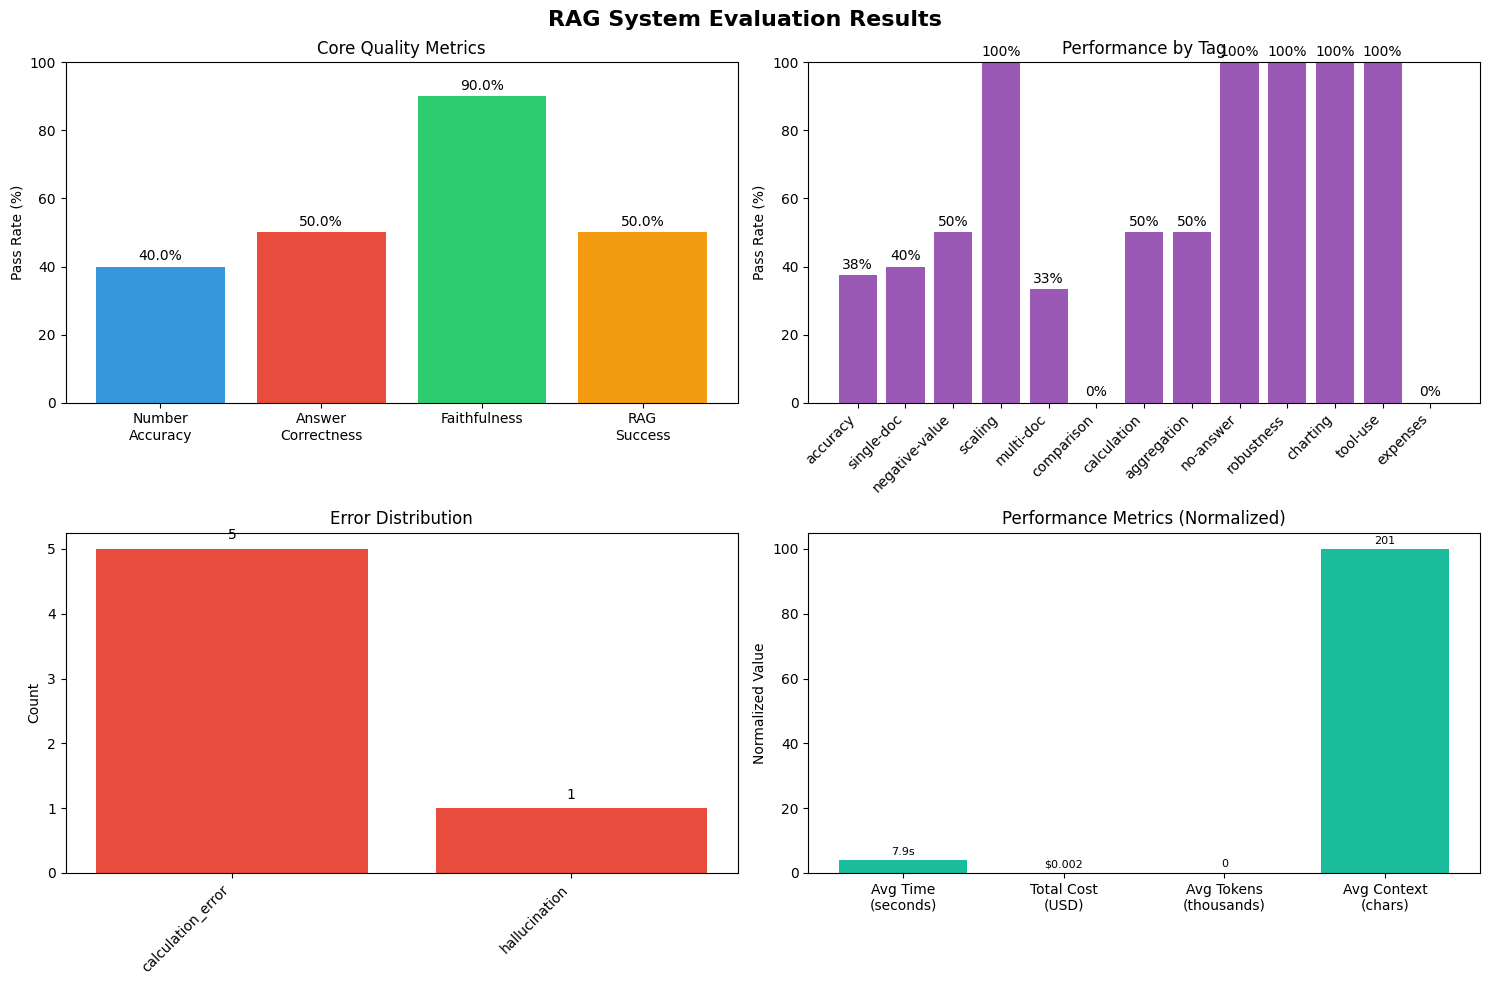


RESULTS SUMMARY
Tests: 10
Success Rate: 100.0%
Number Accuracy: 40.0%
Answer Correctness: 50.0%
Faithfulness: 90.0%
RAG Success: 50.0%
Avg Time: 7.9s
Total Cost: $0.0024

Overall Score: 57.5%
Status: 🟠 MODERATE - Significant Work Required


In [10]:
# Only create visualizations if we have results
if results_df is not None and 'analysis' in locals():
    def create_visualizations(df: pd.DataFrame, analysis: Dict[str, Any]):
        """Create result visualizations."""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('RAG System Evaluation Results', fontsize=16, fontweight='bold')
        
        # Core metrics
        ax1 = axes[0, 0]
        metrics = analysis['metrics']
        metric_names = ['Number\nAccuracy', 'Answer\nCorrectness', 'Faithfulness', 'RAG\nSuccess']
        scores = [metrics['number_accuracy'], metrics['answer_correctness'], 
                  metrics['faithfulness'], metrics['rag_success']]
        
        bars = ax1.bar(metric_names, scores, color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'])
        ax1.set_title('Core Quality Metrics')
        ax1.set_ylabel('Pass Rate (%)')
        ax1.set_ylim(0, 100)
        
        for bar, score in zip(bars, scores):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{score:.1f}%', ha='center', va='bottom')
        
        # Tag performance
        ax2 = axes[0, 1]
        tag_scores = analysis['tag_scores']
        if tag_scores:
            tags = list(tag_scores.keys())
            scores = list(tag_scores.values())
            
            bars = ax2.bar(tags, scores, color='#9b59b6')
            ax2.set_title('Performance by Tag')
            ax2.set_ylabel('Pass Rate (%)')
            ax2.set_ylim(0, 100)
            plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
            
            for bar, score in zip(bars, scores):
                height = bar.get_height()
                ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
                        f'{score:.0f}%', ha='center', va='bottom')
        
        # Error distribution
        ax3 = axes[1, 0]
        error_counts = analysis['error_counts']
        if error_counts:
            errors = list(error_counts.keys())
            counts = list(error_counts.values())
            
            bars = ax3.bar(errors, counts, color='#e74c3c')
            ax3.set_title('Error Distribution')
            ax3.set_ylabel('Count')
            plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')
            
            for bar, count in zip(bars, counts):
                height = bar.get_height()
                ax3.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                        str(count), ha='center', va='bottom')
        else:
            ax3.text(0.5, 0.5, 'No Errors Detected ✓', ha='center', va='center',
                    transform=ax3.transAxes, fontsize=14, color='green')
            ax3.set_title('Error Distribution')
        
        # Performance metrics
        ax4 = axes[1, 1]
        perf = analysis['performance']
        perf_labels = ['Avg Time\n(seconds)', 'Total Cost\n(USD)', 'Avg Tokens\n(thousands)', 'Avg Context\n(chars)']
        perf_values = [
            perf['avg_execution_time'],
            perf['total_cost'],
            perf['avg_tokens'] / 1000,
            perf['avg_context_length']
        ]
        
        # Normalize for display (handle case where all values might be 0)
        max_val = max(perf_values) if max(perf_values) > 0 else 1
        normalized_values = [v/max_val*100 for v in perf_values]
        
        bars = ax4.bar(perf_labels, normalized_values, color='#1abc9c')
        ax4.set_title('Performance Metrics (Normalized)')
        ax4.set_ylabel('Normalized Value')
        
        # Add actual values as text
        for i, (bar, actual) in enumerate(zip(bars, perf_values)):
            height = bar.get_height()
            label = perf_labels[i]
            
            if 'Time' in label:
                text = f'{actual:.1f}s'
            elif 'Cost' in label:
                text = f'${actual:.3f}'
            elif 'Tokens' in label:
                text = f'{actual:.0f}'
            else:
                text = f'{actual:.0f}'
            
            ax4.text(bar.get_x() + bar.get_width()/2., height + 1,
                    text, ha='center', va='bottom', fontsize=8)
        
        plt.tight_layout()
        plt.show()

    # Create visualizations
    create_visualizations(results_df, analysis)

    # Print summary
    print("\n" + "="*40)
    print("RESULTS SUMMARY")
    print("="*40)

    metrics = analysis['metrics']
    performance = analysis['performance']

    print(f"Tests: {analysis['total_tests']}")
    print(f"Success Rate: {metrics['execution_success_rate']:.1f}%")
    print(f"Number Accuracy: {metrics['number_accuracy']:.1f}%")
    print(f"Answer Correctness: {metrics['answer_correctness']:.1f}%")
    print(f"Faithfulness: {metrics['faithfulness']:.1f}%")
    print(f"RAG Success: {metrics['rag_success']:.1f}%")
    print(f"Avg Time: {performance['avg_execution_time']:.1f}s")
    print(f"Total Cost: ${performance['total_cost']:.4f}")

    # Overall assessment
    avg_score = sum([metrics['number_accuracy'], metrics['answer_correctness'], 
                    metrics['faithfulness'], metrics['rag_success']]) / 4

    if avg_score >= 85:
        status = "🟢 EXCELLENT - Production Ready"
    elif avg_score >= 70:
        status = "🟡 GOOD - Minor Improvements Needed"
    elif avg_score >= 50:
        status = "🟠 MODERATE - Significant Work Required"
    else:
        status = "🔴 POOR - Major Rework Needed"

    print(f"\nOverall Score: {avg_score:.1f}%")
    print(f"Status: {status}")
    print("="*40)
    
else:
    print("⚠️  Cannot create visualizations without evaluation results")
    print("Please run the evaluation first or ensure CSV results file exists")